In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc

In [ ]:
import kagglehub

#carregando o dataset através do kaggle
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

#conferindo o caminho salvo
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [ ]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Aplican a Tecnica de Oversampling

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
#centralizae e escalar time e amount, as colunas passam a ter media 0 e desvio padrao 1, assim o modelo irá comparar de forma justa todas as colunas
from sklearn.preprocessing import StandardScaler

df_proc = df.copy()

scaler = StandardScaler()

df_proc['scaled_amount'] = scaler.fit_transform(df_proc['Amount'].values.reshape(-1, 1))
df_proc['scaled_time'] = scaler.fit_transform(df_proc['Time'].values.reshape(-1, 1))

df_proc = df_proc.drop(['Time', 'Amount'], axis=1)

In [ ]:
#separando as classes que queremos prever e as features
X = df_proc.drop('Class', axis=1)
y = df_proc['Class']

#verificando o desbalanceamento
print("Distribuição das Classes (Antes do Oversampling):")
print(y.value_counts(normalize=True))

Distribuição das Classes (Antes do Oversampling):
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [ ]:
#divisao em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Oversampling


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#verificando nova distribuicao
print("\nDistribuição após RandomOverSampler:")
print(pd.Series(y_train_ros).value_counts())


Distribuição após RandomOverSampler:
Class
0    227451
1    227451
Name: count, dtype: int64


# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#verificando nova distribuicao
print("\nDistribuição após SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Distribuição após SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


# Treinando Modelo

Usando SMOTE

In [ ]:
#optei em usar Random Forest ao inves da Decision Tree
from sklearn.ensemble import RandomForestClassifier

#treinando o modelo com SMOTE
model = RandomForestClassifier(random_state=42, n_jobs=-1)

print("\nIniciando o treinamento do modelo...")
model.fit(X_train_smote, y_train_smote)
print("Treinamento concluído.")


Iniciando o treinamento do modelo...
Treinamento concluído.



--- Relatório de Classificação (Dados de Teste) ---
                precision    recall  f1-score   support

Não Fraude (0)       1.00      1.00      1.00     56864
    Fraude (1)       0.81      0.81      0.81        98

      accuracy                           1.00     56962
     macro avg       0.91      0.90      0.90     56962
  weighted avg       1.00      1.00      1.00     56962


--- Matriz de Confusão ---
[[56846    18]
 [   19    79]]


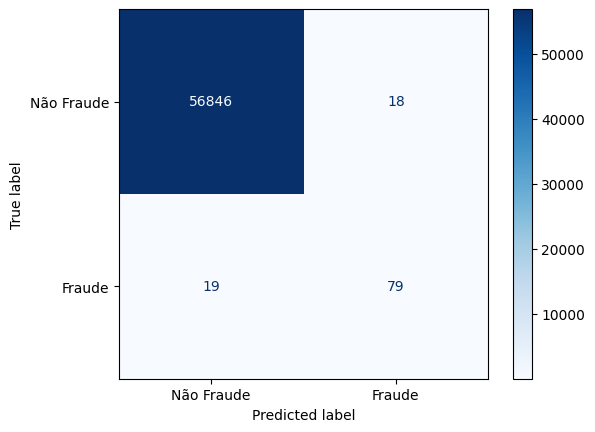

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#fazemos a previsão nos dados de TESTE (originais, desbalanceados)
y_pred = model.predict(X_test)

#relatório de classificação
print("\n--- Relatório de Classificação (Dados de Teste) ---")
#Usamos target_names para facilitar a leitura
print(classification_report(y_test, y_pred, target_names=['Não Fraude (0)', 'Fraude (1)']))

#matriz de confusão
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

#plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Fraude', 'Fraude'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Usando ROS (RandomOverSampler)

In [ ]:
model_ros = RandomForestClassifier(random_state=42, n_jobs=-1)
print("\nIniciando o treinamento do modelo RandomForest (com dados ROS)...")
model_ros.fit(X_train_ros, y_train_ros)
print("Treinamento concluído!")
print("\nModelo 'model_ros' treinado e pronto para fazer previsões.")


Iniciando o treinamento do modelo RandomForest (com dados ROS)...
Treinamento concluído!

Modelo 'model_ros' treinado e pronto para fazer previsões.


Avaliando o modelo 'model_ros' nos dados de TESTE...

--- Relatório de Classificação (RandomOversampler) ---
                precision    recall  f1-score   support

Não Fraude (0)       1.00      1.00      1.00     56864
    Fraude (1)       0.94      0.78      0.85        98

      accuracy                           1.00     56962
     macro avg       0.97      0.89      0.92     56962
  weighted avg       1.00      1.00      1.00     56962


--- Matriz de Confusão (RandomOversampler) ---


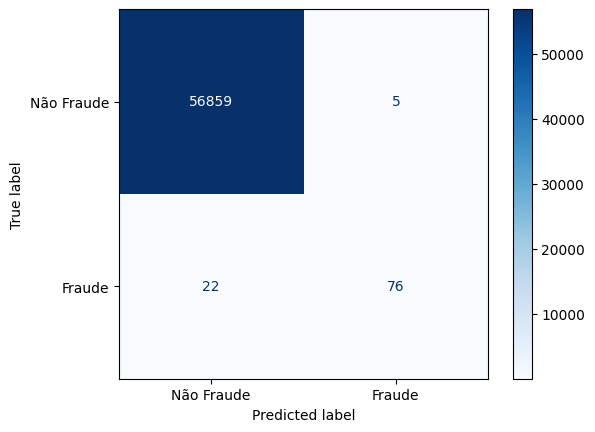

In [ ]:
print("Avaliando o modelo 'model_ros' nos dados de TESTE...")

#fazer previsões nos dados de TESTE
y_pred_ros = model_ros.predict(X_test)

#mostrar relatório de classificação
print("\n--- Relatório de Classificação (RandomOversampler) ---")
print(classification_report(y_test, y_pred_ros, target_names=['Não Fraude (0)', 'Fraude (1)']))

#mostrar matriz de confusão
print("\n--- Matriz de Confusão (RandomOversampler) ---")
cm_ros = confusion_matrix(y_test, y_pred_ros)

#plotar a matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ros, display_labels=['Não Fraude', 'Fraude'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Undersampling (Random)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

print(f"Formato original de X_train: {X_train.shape}")
print(f"Distribuição original de y_train:\n{y_train.value_counts()}")

rus = RandomUnderSampler(random_state=42)
#aplicar o undersampling APENAS no conjunto de treino
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("\n--- Após RandomUnderSampler ---")
print(f"Novo formato de X_train_rus: {X_train_rus.shape}")
print(f"Nova distribuição de y_train_rus:\n{pd.Series(y_train_rus).value_counts()}")

Formato original de X_train: (227845, 30)
Distribuição original de y_train:
Class
0    227451
1       394
Name: count, dtype: int64

--- Após RandomUnderSampler ---
Novo formato de X_train_rus: (788, 30)
Nova distribuição de y_train_rus:
Class
0    394
1    394
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rus = RandomForestClassifier(random_state=42, n_jobs=-1)
print("\nIniciando treinamento com dados de Undersampling (RUS)...")
model_rus.fit(X_train_rus, y_train_rus)
print("Treinamento concluído.")


Iniciando treinamento com dados de Undersampling (RUS)...
Treinamento concluído.



Avaliando o modelo 'model_rus' nos dados de TESTE (originais)...

--- Relatório de Classificação (RandomUnderSampler) ---
                precision    recall  f1-score   support

Não Fraude (0)       1.00      0.96      0.98     56864
    Fraude (1)       0.04      0.91      0.08        98

      accuracy                           0.96     56962
     macro avg       0.52      0.94      0.53     56962
  weighted avg       1.00      0.96      0.98     56962



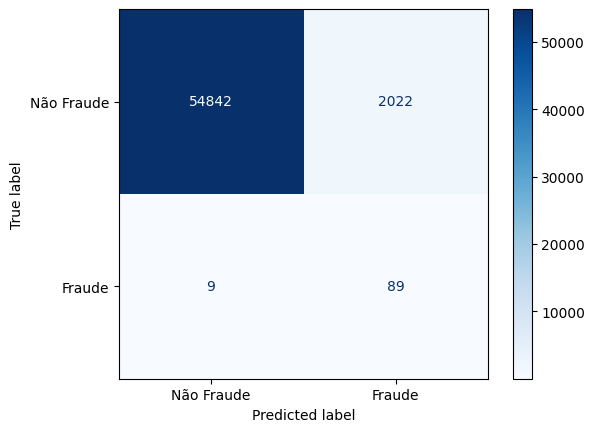

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\nAvaliando o modelo 'model_rus' nos dados de TESTE (originais)...")

#fazer previsões nos dados de TESTE
y_pred_rus = model_rus.predict(X_test)

#mostrar Relatório de Classificação
print("\n--- Relatório de Classificação (RandomUnderSampler) ---")
print(classification_report(y_test, y_pred_rus, target_names=['Não Fraude (0)', 'Fraude (1)']))

#mostrar Matriz de Confusão
cm_rus = confusion_matrix(y_test, y_pred_rus)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rus, display_labels=['Não Fraude', 'Fraude'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Conclusao

-Random Oversampling (ROS): Aumentou significativamente o recall da classe minoritária (Fraude), mas pode ter gerado um modelo um pouco mais propenso a falsos positivos em comparação com o SMOTE (embora a precisão ainda seja alta, 0.94). A matriz de confusão do ROS mostra mais Verdadeiros Positivos (TP) e alguns Falsos Positivos (FP).

-SMOTE: Também melhorou o recall da classe minoritária e apresentou uma precisão ligeiramente menor (0.81) em comparação com o ROS, mas com um f1-score similar. A matriz de confusão do SMOTE mostra um bom equilíbrio entre TP e FP.

-Random UnderSampler (RUS): Reduziu drasticamente o tamanho do conjunto de treino. Embora tenha atingido um recall muito alto para a classe minoritária (0.91), a precisão para a classe minoritária foi muito baixa (0.04). Isso significa que o modelo treinado com RUS identificou a maioria das fraudes (alto recall), mas também gerou um número muito grande de falsos positivos (baixa precisão), tornando-o menos prático em um cenário real onde falsos alarmes são custosos. A matriz de confusão do RUS confirma um grande número de Falsos Positivos.

Comparando as três técnicas aplicadas:

O Random UnderSampler (RUS), embora tenha um alto recall, gerou um número excessivo de falsos positivos, tornando-o menos ideal para este caso.
Tanto o Random Oversampling (ROS) quanto o SMOTE foram eficazes em melhorar a capacidade do modelo de detectar fraudes (aumentando o recall) em comparação com um cenário sem balanceamento.
A escolha entre SMOTE e ROS dependeria dos requisitos específicos do problema:

Se minimizar Falsos Negativos (não detectar uma fraude real) for a prioridade máxima, mesmo que isso resulte em mais Falsos Positivos, o ROS pode ser ligeiramente preferível (maior recall em 0.81 vs 0.78).
Se houver uma necessidade de equilibrar a detecção de fraudes com a minimização de falsos alarmes, o SMOTE (com precisão de 0.81 e recall de 0.81) parece oferecer um bom compromisso neste caso específico.